In [4]:
import requests
from bs4 import BeautifulSoup
import pdftotext
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [75]:
def getPapersForYear(year):
    '''
        Input: year of Proceedings to scrape
        Output: A list of papers, each has the format {"title":, "paper_link":, "supplemental_link":}
    '''
    # Get Links to All Paper Abstracts 
    root_url = "https://www.ijcai.org/proceedings/"
    resp = requests.get(root_url + str(year))
    
    mainPage_html = BeautifulSoup(resp.content, 'html.parser')
    papers = []
    if year > 2016:
        paper_divs = mainPage_html.find_all('div', "paper_wrapper")
        for paper_div in paper_divs:
            title = "Initial Title"
            try:
                title_div = paper_div.find("div", "title")
                assert title_div != None

                title = title_div.text
                paper_title_links = {"title": title, "year": str(year)}
                links_a = paper_div.find_all("a")
                for link_a in links_a:
                    if ".pdf" in link_a["href"]:
                        paper_title_links["paper_link"] = root_url + str(year) + "/" + link_a["href"]
                        break
                assert len(paper_title_links) > 1
                papers.append(paper_title_links)
            except:
                print(title)
                continue
    elif year > 2013:
        links_a = [link_a for link_a in mainPage_html.find_all('a') if ".pdf" in link_a["href"]]
        for link_a in links_a:
            title = "Initial Title"
            try:
                title_raw = [sibling for sibling in link_a.previous_siblings][5]
                title = "/".join(title_raw.split("/")[:-1]).strip()
                paper_title_links = {
                    "title": title,\
                    "year": str(year),\
                    "paper_link": "https://www.ijcai.org" + link_a["href"]}
                papers.append(paper_title_links)
            except:
                print(title)
                continue
    else: 
        links_a = [link_a for link_a in mainPage_html.find_all('a') if ".pdf" in link_a["href"]]
        for link_a in links_a:
            paper_title_links = {
                "title": link_a.text,\
                "year": str(year),\
                "paper_link": link_a["href"]}
            papers.append(paper_title_links)
            
    with open("pickles/ijcai_papers_" + str(year) + ".pickle", "wb") as pickleFile:
        description = "list of paper metadata from IJCAI. Each entry is a dictionary containing\
        the paper title, link to paper pdf (if it exists), and link to supplemental materials (if it exists)"
        pickle.dump((description, papers), pickleFile)
    return papers    

In [62]:
# Within Each Abstract, Download the paper and supplemental materials
def extractTextFromURL(paper):
    pdftxt = ""
    try:
        if "paper_link" in paper:
            #Download PDF
            with open('papers/' + paper["title"] + ".pdf", "wb") as pdfFile:
                rsp = requests.get(paper["paper_link"])
                pdfFile.write(rsp.content)

            #Extract Text
            with open('papers/' + paper["title"] + ".pdf", "rb") as pdfFile:
                pdf = pdftotext.PDF(pdfFile)
                pdftxt += "\n\n".join(pdf)

            #Delete PDF
            os.remove('papers/' + paper["title"] + ".pdf")

        if "supplemental_link" in paper:
            #Download PDF
            with open('supplemental/' + paper["title"] + ".pdf", "wb") as pdfFile:
                rsp = requests.get(paper["supplemental_link"])
                pdfFile.write(rsp.content)

            #Extract Text
            with open('supplemental/' + paper["title"] + ".pdf", "rb") as pdfFile:
                pdf = pdftotext.PDF(pdfFile)
                pdftxt += "\n\n".join(pdf)

            #Delete PDF
            os.remove('supplemental/' + paper["title"] + ".pdf")
    except:
        print("Could not extract text for: " + paper["title"])
    return pdftxt.lower()

In [63]:
def parsePaper(paper, pdftxt, parsed_papers):
    keywords = [\
               ("Github", "github.com"),\
               ("GPU", "gpu"),\
               ("Reproducibility", "reproducibility"),\
               ("Broader Impact", "broader impact")]

    parsed_paper = {"title": paper["title"], "year": paper["year"]}
    for key, value in keywords:
        parsed_paper[key] = int(value in pdftxt)
    parsed_papers.append(parsed_paper)

In [81]:
papers = getPapersForYear(2017)
print(papers[10])
len(papers)

{'title': 'An Abstraction-Refinement Methodology for Reasoning about Network Games', 'year': '2017', 'paper_link': 'https://www.ijcai.org/proceedings/2017/0011.pdf'}


781

In [83]:
years = [2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2011]
parsed_papers = []
for year in years:
    print(str(year))
    papers = getPapersForYear(year)
    print("Finished getting links")
    for paper in papers:
        pdftxt = extractTextFromURL(paper)
        #saveBroaderImpact(paper, pdftxt)
        parsePaper(paper, pdftxt, parsed_papers)
    
    parsed_papers_pd = pd.DataFrame(parsed_papers)
    with open("pickles/ijcai_parsed_papers_pd.pickle", "wb") as pickleFile:
        description = "table with statistics of interest for IJCAI papers. Each paper is a row in which\
        we indicate the desired properties that are satisfied."
        pickle.dump((description, parsed_papers_pd), pickleFile)

2020
Finished getting links
Could not extract text for: Scaling Up AND/OR Abstraction Sampling
Could not extract text for: The Blind Men and the Elephant: Integrated Offline/Online Optimization Under Uncertainty
2019
Finished getting links
Could not extract text for: Depth-First Memory-Limited AND/OR Search and Unsolvability in Cyclic Search Spaces
Could not extract text for: Planning for LTLf /LDLf Goals in Non-Markovian Fully Observable Nondeterministic Domains
2018
Finished getting links
Could not extract text for: Methods for off-line/on-line optimization under uncertainty
Could not extract text for: Complexity of Approximate Query Answering under Inconsistency in Datalog+/-
Could not extract text for: Assigning Personality/Profile to a Chatting Machine for Coherent Conversation Generation
2017
Finished getting links
Could not extract text for: Causal Discovery from Nonstationary/Heterogeneous Data: Skeleton Estimation and Orientation Determination
Could not extract text for: Towar

In [84]:
parsed_papers_pd = pd.DataFrame(parsed_papers)
with open("pickles/ijcai_parsed_papers_pd.pickle", "wb") as pickleFile:
    description = "table with statistics of interest for neurips 2002 papers. Each paper is a row in which\
    we indicate the desired properties that are satisfied."
    pickle.dump((description, parsed_papers_pd), pickleFile)

In [85]:
with open("pickles/ijcai_parsed_papers_pd.pickle", "rb") as pickleFile:
    description, parsed_papers_pd = pickle.load(pickleFile)

parsed_papers_pd.groupby("year").mean()

,Github,GPU,Reproducibility,Broader Impact
year,,,,
2011,0.000000,0.003945,0.003945,0.001972
2013,0.009785,0.009785,0.003914,0.000000
2015,0.038110,0.012195,0.001524,0.000000
2016,0.072948,0.042553,0.009119,0.000000
2017,0.134443,0.083227,0.011524,0.001280
2018,0.175862,0.121839,0.013793,0.000000
2019,0.274896,0.134855,0.013485,0.000000
2020,0.305520,0.150193,0.019255,0.000000


Text(0.5, 1.0, 'Fraction of IJCAI papers containing computing keywords (2011-2020)')

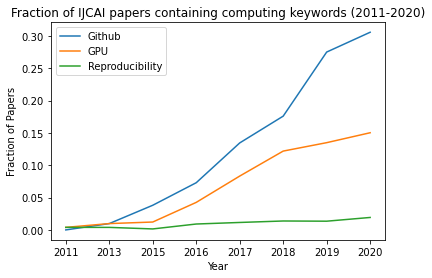

In [87]:
ax = plt.subplot()
parsed_papers_pd[["year", "Github", "GPU", "Reproducibility"]].groupby("year").mean().plot(ax=ax)
ax.set_xlabel("Year")
ax.set_ylabel("Fraction of Papers")
ax.set_title("Fraction of IJCAI papers containing computing keywords (2011-2020)")

0                              Compositional Plan Vectors
1           Learning to Propagate for Graph Meta-Learning
2       XNAS: Neural Architecture Search with Expert A...
3          Multi-resolution Multi-task Gaussian Processes
4                                 Deep Equilibrium Models
                              ...                        
7426                Pylon Model for Semantic Segmentation
7427               How biased are maximum entropy models?
7428         Gaussian process modulated renewal processes
7429    An ideal observer model for identifying the re...
7430    Greedy Algorithms for Structurally Constrained...
Name: title, Length: 7431, dtype: object